In [1]:
import gym
import or_gym
from pyomo.environ import *
from or_gym.algos.math_prog_utils import *
import numpy as np
import copy
import time
from collections import Iterable

# Perfect Information Model

In [26]:
env_name = 'Knapsack-v2'
env = gym.make(env_name)
# Selected items 
ordered_items = np.random.choice(env.item_numbers, p=env.item_probs, size=env.step_limit)
ordered_weights = [env.item_weights[i] for i in ordered_items]
ordered_values = [env.item_values[i] for i in ordered_items]
# Initialize model
m = ConcreteModel()

# Sets, parameters, and variables
m.W = env.max_weight
m.T = env.step_limit

m.i = Set(initialize=np.arange(len(ordered_items)))

m.w = Param(m.i, 
    initialize={i: j for i, j in zip(np.arange(len(ordered_items)), ordered_weights)})
m.v = Param(m.i, 
    initialize={i: j for i, j in zip(np.arange(len(ordered_items)), ordered_values)})

m.x = Var(m.i, within=Binary)

@m.Constraint()
def weight_constraint(m):
    return sum(m.w[i] * m.x[i] 
               for i in m.i) - m.W <= 0
    
@m.Constraint()
def selection_constraint(m):
    return sum(m.x[i] for i in m.i) - m.T <= 0

m.obj = Objective(expr=(
    sum([m.v[i] * m.x[i] for i in m.i])),
    sense=maximize)

In [27]:
model, results = solve_math_program(m, 'gurobi')
print(model.obj.expr())

Read LP format model from file /tmp/tmp9zjuppge.pyomo.lp
Reading time = 0.00 seconds
x51: 3 rows, 51 columns, 101 nonzeros
Optimize a model with 3 rows, 51 columns and 101 nonzeros
Variable types: 1 continuous, 50 integer (50 binary)
Coefficient statistics:
  Matrix range     [1e+00, 2e+01]
  Objective range  [1e+00, 3e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 2e+02]
Found heuristic solution: objective 354.0000000
Presolve removed 2 rows and 12 columns
Presolve time: 0.00s
Presolved: 1 rows, 39 columns, 39 nonzeros
Variable types: 0 continuous, 39 integer (33 binary)

Root relaxation: objective 4.850000e+02, 1 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0  485.00000    0    1  354.00000  485.00000  37.0%     -    0s
H    0     0                     481.0000000  485.00000  0.83%     -    0s

Cutting planes:
  Gomory: 1

E

In [24]:
selected_items = np.array([i for i in m.x if m.x[i].value > 0])
np.array(ordered_weights)[selected_items].sum()

200

In [25]:
np.array(ordered_values)[selected_items].sum()

380

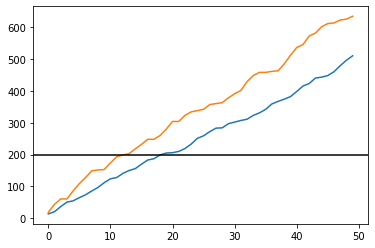

In [15]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure()
plt.plot(np.cumsum(x[:,0]))
plt.plot(np.cumsum(x[:,1]))
plt.axhline(env.max_weight, c='k')
plt.show()

# Online Stochastic Optimization

In [61]:
env_name = 'Knapsack-v2'
env = gym.make(env_name)
env.item_values = np.array([10, 5])
env.item_probs = np.array([0.75, 0.25])
env.item_weights = np.array([2, 1])
env.N = 2
env.item_numbers = np.arange(env.N)
env.step_limit = 2

# Initialize model
m = ConcreteModel()

# Sets, parameters, and variables
m.W = env.max_weight
m.T = env.step_limit

m.i = Set(initialize=env.item_numbers)
m.t = RangeSet(0, m.T - 1) # Time steps
m.s = Set(initialize=env.item_numbers) # Scenarios

m.w = Param(m.i, 
    initialize={i: j for i, j in zip(env.item_numbers, env.item_weights)})
m.v = Param(m.i, 
    initialize={i: j for i, j in zip(env.item_numbers, env.item_values)})
m.p = Param(m.i,
    initialize={i: j for i, j in zip(env.item_numbers, env.item_probs)})

m.x = Var(m.i, m.t, m.s, within=Binary)

@m.Constraint()
def weight_constraint(m):
    return sum(m.w[i] * m.x[i, t, s] 
               for i in m.i
               for t in m.t 
               for s in m.s) - m.W <= 0

@m.Constraint(m.t, m.s)
def assignment_constraint(m, t, s):
    return sum(m.x[i, t, s] 
               for i in m.i
               for s in m.s) <= 1

@m.Constraint(m.i, m.t, m.s)
def scenario_constraints(m, i, t, s):
    if i == s:
        return (m.x[i, t, s] <= 1)
    else:
        return (m.x[i, t, s] == 0)


m.obj = Objective(expr=(
    sum([m.v[i] * m.x[i, t, s] 
         for i in m.i
         for t in m.t
         for s in m.s])),
    sense=maximize)

In [62]:
model, results = solve_math_program(m, solver='gurobi')

Read LP format model from file /tmp/tmph5_8jd8h.pyomo.lp
Reading time = 0.00 seconds
x9: 14 rows, 9 columns, 33 nonzeros
Optimize a model with 14 rows, 9 columns and 33 nonzeros
Variable types: 1 continuous, 8 integer (8 binary)
Coefficient statistics:
  Matrix range     [1e+00, 2e+00]
  Objective range  [5e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 2e+01]
Presolve removed 14 rows and 9 columns
Presolve time: 0.00s
Presolve: All rows and columns removed

Explored 0 nodes (0 simplex iterations) in 0.00 seconds
Thread count was 1 (of 8 available processors)

Solution count 1: 20 

Optimal solution found (tolerance 1.00e-04)
Best objective 2.000000000000e+01, best bound 2.000000000000e+01, gap 0.0000%


In [63]:
model.obj.expr()

20.0

In [60]:
[print(i, m.x[i].value) for i in m.x if m.x[i].value > 0]

(0, 0, 0) 1.0
(0, 1, 0) 1.0


[None, None]

In [71]:
# LP Approximation
env_name = 'Knapsack-v2'
env = gym.make(env_name)
env.item_values = np.array([10, 5])
env.item_probs = np.array([0.75, 0.25])
env.item_weights = np.array([2, 1])
env.N = 2
env.item_numbers = np.arange(env.N)
env.step_limit = 2

# Initialize model
m = ConcreteModel()

# Sets, parameters, and variables
m.W = env.max_weight
m.T = env.step_limit

m.i = Set(initialize=env.item_numbers)
m.t = RangeSet(0, m.T - 1) # Time steps
m.s = Set(initialize=env.item_numbers) # Scenarios

m.w = Param(m.i, 
    initialize={i: j for i, j in zip(env.item_numbers, env.item_weights)})
m.v = Param(m.i, 
    initialize={i: j for i, j in zip(env.item_numbers, env.item_values)})
m.p = Param(m.i,
    initialize={i: j for i, j in zip(env.item_numbers, env.item_probs)})

m.x = Var(m.i, m.t, within=NonNegativeReals)

@m.Constraint()
def weight_constraint(m):
    return sum(m.w[i] * m.x[i, t] * m.p[i]
               for i in m.i
               for t in m.t) - m.W <= 0

@m.Constraint(m.t)
def assignment_constraint(m, t):
    return sum(m.x[i, t]
               for i in m.i) <= 1

# @m.Constraint(m.i, m.t)
# def scenario_constraints(m, i, t):
#     if i == s:
#         return (m.x[i, t, s] <= 1)
#     else:
#         return (m.x[i, t, s] == 0)


m.obj = Objective(expr=(
    sum([m.v[i] * m.x[i, t] * m.p[i]
         for i in m.i
         for t in m.t])),
    sense=maximize)

model, results = solve_math_program(m, 'gurobi')
print(model.obj.expr())

Read LP format model from file /tmp/tmpd4exmg_i.pyomo.lp
Reading time = 0.00 seconds
x5: 4 rows, 5 columns, 9 nonzeros
Optimize a model with 4 rows, 5 columns and 9 nonzeros
Coefficient statistics:
  Matrix range     [2e-01, 2e+00]
  Objective range  [1e+00, 8e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 2e+01]
Presolve removed 4 rows and 5 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    1.5000000e+01   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds
Optimal objective  1.500000000e+01
15.0


In [72]:
[m.x[i].value for i in m.x]

[1.0, 1.0, 0.0, 0.0]

# Online Knapsack Heuristic

Naive greedy algorithm, use as a placeholder. Take the item if the item fits and is greater than the average weighted value density of all items. Decrease this threshold with each sample until the sack is full or the episode ends.

In [2]:
env = gym.make('Knapsack-v2')

In [5]:
env.reset()
vw_ratio = env.item_values / env.item_weights
T = np.mean(vw_ratio)
item = copy.copy(env.current_item)
done = False
actions = []
items_taken = []
items_offered = []
rewards = []
count = 0
while not done:
    if env.item_weights[item] >= (env.max_weight - env.current_weight):
        action = 0
    elif vw_ratio[item] >= T / (1 + count):
        action = 1
        items_taken.append(item)
    else:
        action = 0
    state, reward, done, _ = env.step(action)
    actions.append(action)
    rewards.append(reward)
    items_offered.append(item)
    item = state[-1][-1]
    count += 1
    print(count)

1
2
3
4
5


In [9]:
def okp_heuristic_decay(env, scenario=None):
    assert env.spec.id == 'Knapsack-v2', \
        '{} received. Heuristic designed for Knapsack-v2.'.format(env.spec.id)
    if scenario is not None:
        # Ensure scenario is iterable of length step_limit
        assert isinstance(scenario, Iterable), 'scenario not iterable.'
        assert len(scenario) >= env.step_limit, 'scenario too short.'
    env.reset()

    vw_ratio = env.item_values / env.item_weights
    T = np.mean(vw_ratio)
    done = False
    actions = []
    items_taken = []
    items_offered = []
    rewards = []
    count = 0
    while not done:
        if scenario is not None:
            item = scenario[count]
        else:
            item = copy.copy(env.current_item)
        if env.item_weights[item] >= (env.max_weight - env.current_weight):
            action = 0
        elif vw_ratio[item] >= T / (1 + count):
            action = 1
            items_taken.append(item)
        else:
            action = 0
        state, reward, done, _ = env.step(action)
        actions.append(action)
        rewards.append(reward)
        items_offered.append(item)
        count += 1

    return actions, items_offered, rewards

def okp_heuristic(env, scenario=None):
    assert env.spec.id == 'Knapsack-v2', \
        '{} received. Heuristic designed for Knapsack-v2.'.format(env.spec.id)
    if scenario is not None:
        # Ensure scenario is iterable of length step_limit
        assert isinstance(scenario, Iterable), 'scenario not iterable.'
        assert len(scenario) >= env.step_limit, 'scenario too short.'
    env.reset()

    vw_ratio = env.item_values / env.item_weights
    T = np.mean(vw_ratio)
    done = False
    actions = []
    items_taken = []
    items_offered = []
    rewards = []
    count = 0
    while not done:
        if scenario is not None:
            item = scenario[count]
        else:
            item = copy.copy(env.current_item)
        if env.item_weights[item] >= (env.max_weight - env.current_weight):
            action = 0
        elif vw_ratio[item] >= T:
            action = 1
            items_taken.append(item)
        else:
            action = 0
        state, reward, done, _ = env.step(action)
        actions.append(action)
        rewards.append(reward)
        items_offered.append(item)
        count += 1

    return actions, items_offered, rewards

def two_bin(env, scenario):
    assert env.spec.id == 'Knapsack-v2', \
        '{} received. Heuristic designed for Knapsack-v2.'.format(env.spec.id)
    if scenario is not None:
        # Ensure scenario is iterable of length step_limit
        assert isinstance(scenario, Iterable), 'scenario not iterable.'
        assert len(scenario) >= env.step_limit, 'scenario too short.'
    env.reset()
    
    done = False
    actions = []
    items_taken = []
    items_offered = []
    rewards = []
    count = 0
    while not done:
        if scenario is not None:
            item = scenario[count]
        else:
            item = copy.copy(env.current_item)
            
        r = bool(np.random.choice([0, 1]))
        action = 0
        if r:
            # Greedy algorithm
            if env.item_weights[item] <= (env.max_weight - env.current_weight):
                action = 1

        state, reward, done, _ = env.step(action)
        actions.append(action)
        rewards.append(reward)
        items_offered.append(item)
        count += 1

    return actions, items_offered, rewards

def two_bin2(env, scenario=None):
    '''TwoBins from Han 2015'''
    assert env.spec.id == 'Knapsack-v2', \
        '{} received. Heuristic designed for Knapsack-v2.'.format(env.spec.id)
    if scenario is not None:
        # Ensure scenario is iterable of length step_limit
        assert isinstance(scenario, Iterable), 'scenario not iterable.'
        assert len(scenario) >= env.step_limit, 'scenario too short.'
    env.reset()
    
    done = False
    actions = []
    items_taken = []
    items_offered = []
    rewards = []
    r = bool(np.random.choice([0, 1]))
    rejection_weight = 0
    count = 0
    while not done:
        if scenario is not None:
            item = scenario[count]
        else:
            item = copy.copy(env.current_item)
        action = 0
        if r:
            # Greedy algorithm
            if env.item_weights[item] <= (env.max_weight - env.current_weight):
                action = 1
        else:
        	rejection_weight += env.item_weights[item]
        	if rejection_weight > env.max_weight:
        		action = 1

        state, reward, done, _ = env.step(action)
        actions.append(action)
        rewards.append(reward)
        items_offered.append(item)
        count += 1

    return actions, items_offered, rewards

In [10]:
# Compare heuristic approaches with and without decay
# Keep items constant across all applications
env = gym.make('Knapsack-v2')
N_SCENARIOS = 10000
item_sequence = np.random.choice(env.item_numbers, 
    size=(N_SCENARIOS, env.step_limit), p=env.item_probs)
t0 = time.time()
avg_dec_rewards = 0
for n in range(N_SCENARIOS):
    env.reset()
    actions, items, rewards = okp_heuristic(env, item_sequence[n])
    avg_dec_rewards += (sum(rewards) - avg_dec_rewards) / (n + 1)
print("Average Greedy Decay Heuristic Reward\t=\t{:.2f}".format(avg_dec_rewards))
print("{:.2f}s elapsed".format(time.time() - t0))

t0 = time.time()
avg_heur_rewards = 0
for n in range(N_SCENARIOS):
    env.reset()
    actions, items, rewards = okp_heuristic(env, item_sequence[n])
    avg_heur_rewards += (sum(rewards) - avg_heur_rewards) / (n + 1)
    
print("Average Greedy no Decay Heuristic Reward\t=\t{:.2f}".format(avg_heur_rewards))
print("{:.2f}s elapsed".format(time.time() - t0))

t0 = time.time()
avg_twobin_rewards = 0
for n in range(N_SCENARIOS):
    env.reset()
    actions, items, rewards = two_bin(env, item_sequence[n])
    avg_twobin_rewards += (sum(rewards) - avg_twobin_rewards) / (n + 1)
    
print("Average TwoBins Heuristic Reward\t=\t{:.2f}".format(avg_twobin_rewards))
print("{:.2f}s elapsed".format(time.time() - t0))

t0 = time.time()
avg_twobin2_rewards = 0
for n in range(N_SCENARIOS):
    env.reset()
    actions, items, rewards = two_bin2(env, item_sequence[n])
    avg_twobin2_rewards += (sum(rewards) - avg_twobin2_rewards) / (n + 1)
    
print("Average TwoBin 2 Heuristic Reward\t=\t{:.2f}".format(avg_twobin2_rewards))
print("{:.2f}s elapsed".format(time.time() - t0))

Average Greedy Decay Heuristic Reward	=	139.39
15.48s elapsed
Average Greedy no Decay Heuristic Reward	=	139.16
15.57s elapsed
Average TwoBins Heuristic Reward	=	263.80
21.97s elapsed
Average TwoBin 2 Heuristic Reward	=	269.68
11.45s elapsed
